# This notebook collects and prepare all data used in the Housetrade model
## It consist of data from Statistics Denmark, OK oil and HOFOR.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import pydst
dst = pydst.Dst(lang='da')

# Data from Statistics Denmark on types of houses

In [2]:
# Loading data from table BOL102
House_types = dst.get_data(table_id='BOL102', 
                   variables={'Anvendelse':['*'], 
                              'OPFØRELSESÅR':['*'], 
                              'OPVARMNING':['*'],
                              'Tid':['2020']})


In [3]:
House_types.ANVENDELSE = House_types.ANVENDELSE.apply(lambda x: 'Parcelhuse' if x == 'Parcel/Stuehuse' else x)

In [4]:
House_types[House_types.ANVENDELSE == 'Parcel/Stuehuse'].ANVENDELSE = 'Parcelhuse'

In [5]:
# Selected applications Parcels, townhouses, flats (secound parcels is becouse 
#this variable is used on another table that uses a different declaration for parcels).
types= ['Række-, kæde- og dobbelthuse', 'Etageboliger', 'Parcelhuse']
# Subsetting the dataframe with selected values
House_types = House_types[House_types.ANVENDELSE.isin(types)]


In [6]:
# Selected heatings - centralheating w. gas and oil, distant heating and heatpumps
heatings = ['Centralvarme m naturgas', 'Fjernvarme', 'Varmepumpe', 'Centralvarme med olie']
# Subsetting the with selected values
House_types = House_types[House_types.OPVARMNING.isin(heatings)]

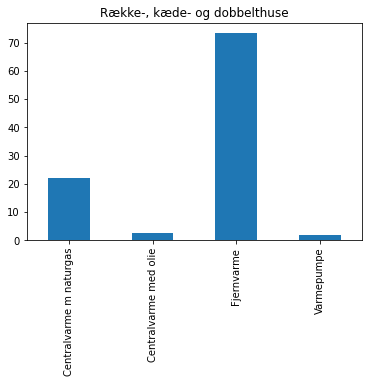

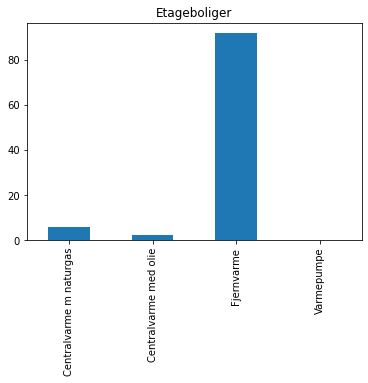

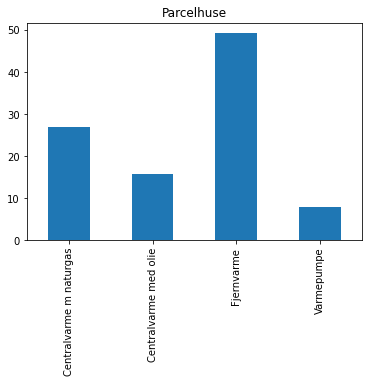

In [7]:
# Create a dictionary for the share of properties by the selected property and heat types.
wh = {}
for it, i in enumerate(types):
    # subset to application in property type
    select = House_types[House_types.ANVENDELSE == i]
    if select.shape[0] == 0:
        # remember we declared parcels in two ways, is no obs we continue
        continue
    else:
        # sum applications by heating system
        OP = select.groupby('OPVARMNING')
        OP = OP.sum().reset_index()
        # find the share, this is to the plot
        OP['Share'] = (OP.INDHOLD.values / sum(OP.INDHOLD.values) ) *100
        # find the share, this is to the dict
        wh[i] = {}
        for idx, j in enumerate(OP.OPVARMNING):
            # this is to keep the index
            wh[i][j] =  OP['Share'].iloc[idx]/100
        
        # display the distributions 
        OP.plot(x ='OPVARMNING' , y = 'Share', kind='bar', legend = False,  title=i, xlabel = '');

# Create a heating system index used to index the weights        
hidx  =OP.OPVARMNING.values

# So, now we have all the weights for the heating systems in each property type. The following will find the weights for the properties.

In [8]:
# Loading data from table BYG12
byg = dst.get_data(table_id='BYGB12', 
                   variables={'ANVEND':['*'], 
                              'AREALINT':['*'],
                              'Tid':['2020']})

In [9]:
# subset dataframe by types, created in section above
byg = byg[byg.ANVEND.isin(types)]
# selected sizes, removing all the vary large properties
sizes = ['100-199 m2', '200-499 m2', '500-999 m2', 'Mindre end 99 m2']
# subset dataframe by the selected sizes
byg = byg[byg.AREALINT.isin(sizes)]

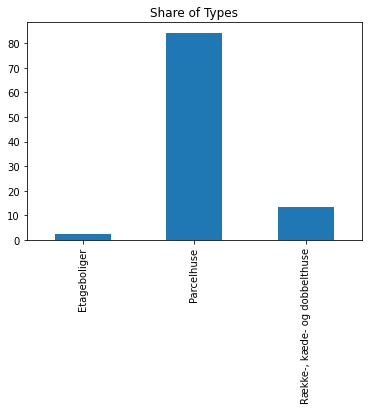

In [10]:
# sum the values by applications
OP = byg.groupby('ANVEND')
OP = OP.sum().reset_index()
# shares for the plot
OP['Share'] = (OP.INDHOLD.values / sum(OP.INDHOLD.values) ) *100
#shares for the dict
wt = OP['Share'].values/100
OP.plot(x ='ANVEND' , y = 'Share', kind='bar', legend = False,  title='Share of Types', xlabel = '');

w_t = {}
#index the dict
for it, j in enumerate(OP.ANVEND):
    w_t[j] = wt[it]
    


In [11]:
# Find all values with 2 digits, i.e. all that says 99 or below
a = byg.AREALINT.str.findall(r"\b\d{2}(?:-\d{2})?\b")
# Find all values with 3 digits i.e. the rest
b = byg.AREALINT.str.findall(r"\b\d{3}(?:-\d{3})?\b")
# add them together, perfect fit
byg.AREALINT = a +b
# the elements are in a list type, here we get the values
byg.AREALINT =byg.AREALINT.str.get(0)
# split the values by - 
byg.AREALINT = byg.AREALINT.str.split('-')
# Calculate the mean size of intervals as the mean of the area sizes bounds, if below 99 the mean is between 0 and 99
byg['mean_size'] = byg.AREALINT.apply(lambda x: round(np.mean([int(x[0]), int(x[1])])) if len(x) > 1 else round(np.mean([int(x[0]), 0])))
# sort the values, so lowest mean sizes comes first
byg = byg.sort_values(by = 'mean_size')

C:\Users\45238\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


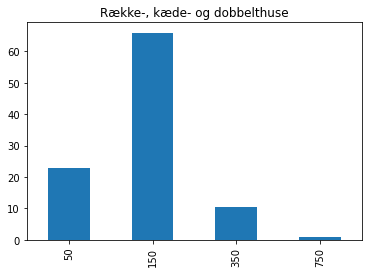

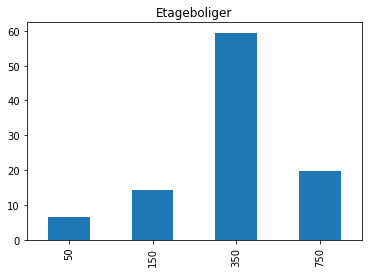

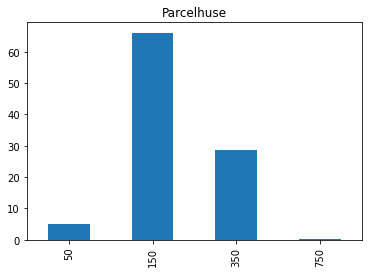

In [12]:
# Create a dictionary for the share of properties by the selected property sizes.
ws = {}
for i in types:
    # subset by application
    select = byg[byg.ANVEND == i]
    if select.shape[0] == 0:
        # remember we have two declarations for parcels
        continue
    else:
        # find share applications by mean sizes
        # first for the plot
        select.loc[:,'Share'] = (select.INDHOLD.values / sum(select.INDHOLD.values) ) *100
        # for the dict.
        #ws[i] = select['Share'].values/100
        ws[i] = {}
        for it, j in enumerate(select.mean_size):
            # this is to keep the index
            ws[i][j] =  select['Share'].iloc[it]/100
        select.plot(x ='mean_size' , y = 'Share', kind='bar', legend = False,  title=i, xlabel = '');


# Collecting the weights

In [13]:
print(ws,'\n') # sizes 
print(w_t,'\n') # types
print(wh,'\n') # heatings

{'Række-, kæde- og dobbelthuse': {50: 0.22834211602638954, 150: 0.6596978121313788, 350: 0.10442612164573245, 750: 0.007533950196499173}, 'Etageboliger': {50: 0.06470551299761397, 150: 0.14309933442170036, 350: 0.5946251412784127, 750: 0.19757001130227303}, 'Parcelhuse': {50: 0.050001798426791574, 150: 0.6606294862678586, 350: 0.28687950817177466, 750: 0.0024892071335751525}} 

{'Etageboliger': 0.024790712588999685, 'Parcelhuse': 0.843906148333328, 'Række-, kæde- og dobbelthuse': 0.13130313907767216} 

{'Række-, kæde- og dobbelthuse': {'Centralvarme m naturgas': 0.21948680828355782, 'Centralvarme med olie': 0.027321263932074614, 'Fjernvarme': 0.7335186100022983, 'Varmepumpe': 0.0196733177820692}, 'Etageboliger': {'Centralvarme m naturgas': 0.057434451157577844, 'Centralvarme med olie': 0.022453928273081944, 'Fjernvarme': 0.9175678528003742, 'Varmepumpe': 0.0025437677689660334}, 'Parcelhuse': {'Centralvarme m naturgas': 0.2693418665591615, 'Centralvarme med olie': 0.1583249344890143, 'F

In [14]:
w_types = []
w = []
for key, value in zip(ws.keys(), ws.values()):
    # key = Række, etage, parcel, value.keys() = 50, 150, 350, 750, 
    for valkey, valval in zip(value.keys(), value.values()):
        # share of size conditional on types
        sct = w_t[key] * valval
        for k, v in zip(wh[key].keys(), wh[key].values()):
            # append the conditional weights and types
            w_types.append(f'{key}, {valkey}, {k}') 
            w.append(sct * v)

In [15]:
data =pd.DataFrame(zip(w_types,w),columns =['types', 'weight'])


# Mean gas prices 2020, before taxes given demand

In [16]:
# get the gas prices
energi = dst.get_data(table_id='ENERGI3', 
                   variables={'AARSFORBRUG':['*'],
                              'Tid':['2020H1', '2020H2']})

In [17]:
# values as floats
energi.INDHOLD =energi.INDHOLD.str.replace(',','.').astype('float')
# mean grouped on yearly consumption
mean_e = energi.groupby('AARSFORBRUG').mean()


# Mean electricity prices 2020 before taxes

In [18]:
# Get the electricity prices
el = dst.get_data(table_id='ENERGI1', 
                   variables={'AARSFORBRUG':['*'],
                              'Tid':['2020H1', '2020H2']})

In [19]:
# values as floats
el.INDHOLD =el.INDHOLD.str.replace(',','.').astype('float')
# mean grouped on consumption
mean_el = el.groupby('AARSFORBRUG').mean()
# all prices are the same, i.e just choose one

# Price on distant heating HOFOR 2020 kr. pr. kW
link: https://www.hofor.dk/privat/priser-paa-forsyninger-privatkunder/tidligere-aars-priser/priser-2020/prisen-paa-fjernvarme-2020-privatkunder/

In [20]:
Fjernvarme = 159,76

# Centralheating oil prices company OK 2020
link: https://www.ok.dk/privat/produkter/fyringsolie/prisudvikling

In [21]:
olie = pd.read_excel('ok_prisudvikling.xlsx')
olie_2020 = olie[(olie.Dato > '2020-01-01') &
          (olie.Dato <= '2020-12-31')]
mean_oil_2020 = olie_2020.Pris.mean()

# Family stat

In [22]:
# Family data
fam = dst.get_data(table_id='FAM44N', 
                   variables={'FAMSTØR':['*'],
                              'ANTBØRN':['*'], 
                              'FAMTYP':['*'], 
                              'Tid':['2020']})

In [23]:
# find digits
fam.FAMSTØR =fam.FAMSTØR.str.replace('\D', '', regex=True).astype(np.int64) 
fam.ANTBØRN = fam.ANTBØRN.str.replace('\D', '', regex = True).astype(np.int64) 

#find number of adults
fam['ANTVOKS'] = fam.FAMSTØR-fam.ANTBØRN
# sum of family size groupd on total size number of adults and children
fam_types = fam.groupby(['FAMSTØR','ANTVOKS', 'ANTBØRN',]).sum()
# share of falily type
fam_types['share'] = fam_types['INDHOLD'] / fam_types['INDHOLD'].sum()
# remove the most odd sizes i.e. if share is below 5 percent
fam_types= fam_types[fam_types.share > 0.05]
# get the updated weights
fam_types.share = fam_types.INDHOLD / fam_types.INDHOLD.sum()